In [7]:
from algorithms.schedules_optimization import  schedule_optimizer_ev, standard_annealing, build_delta,build_omega
from algorithms.hamiltonian import get_mapping
from algorithms.ev_costs import ev_cost, average_ev_cost,qubo_ev, find_gs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import pickle
from itertools import product


import random
from pulser import Pulse, InterpolatedWaveform, DigitalAnalogDevice, Sequence
from pulser_simulation import QutipEmulator

In [8]:
def create_parameters(N,T_ev):

    delta_t = 1.0  # Time step
    P0 = np.ones(N)  # Charging powers

    Lambda = 5  # Regularization parameter

    charging_costs = [random.randint(1, 5)]*T_ev  # Random charging costs

    deltas = [0.3 *x for x in  charging_costs]  # Delta values based on charging costs
    
    if N == 4 and T_ev == 4:
        P = 2
        target_energies = [2,0,4,2]

    if N == 3 and T_ev == 3:
        P = 1
        target_energies = [1,1,1]

    if N == 3 and T_ev == 2:
        P = 1
        target_energies = [0,0,1]

    if N == 2 and T_ev == 2:
        P = 0
        target_energies = [0,0] 
    if N == 6 and T_ev == 2:
        P=0
        target_energies = [0,0,0,0,0,0]

    if N == 4 and T_ev == 3:
        P=1
        target_energies = [1,1,-1,1]
    if N == 5 and T_ev == 2:
        P=1
        target_energies = [0]*N
    if N == 4 and T_ev == 4:
        P=2
        target_energies = [2]*N

    # Pack parameters into a dictionary
    params = {
        "delta_t": delta_t,
        "P0": P0,
        "deltas": deltas,
        "costs": charging_costs,
        "Lambda": Lambda,
        "N": N,
        "T": T_ev,
        "target_energies": target_energies,
        "P": P
    }

    # Generate QUBO matrix and get mapping
    Q = qubo_ev(params)
    reg = get_mapping(Q)

    with open(f"results/parameters_N_{str(N)}_T_{str(T_ev)}.pkl","wb") as fp:
        pickle.dump(params,fp)

    with open(f"results/reg_N_{str(N)}_T_{str(T_ev)}.pkl", 'wb') as fp:
        pickle.dump(reg, fp)

    np.save(f"results/Q_N_{str(N)}_T_{str(T_ev)}",Q)
    np.save(f"results/reg_N_{str(N)}_T_{str(T_ev)}",reg)

    print("Parameters created")

    return

In [9]:
def main(N,T_ev,ii):

    # load registers and problem parameters
    with open(f"results/parameters_N_{str(N)}_T_{str(T_ev)}.pkl","rb") as fp:
        params = pickle.load(fp)
    with open(f"results/reg_N_{str(N)}_T_{str(T_ev)}.pkl","rb") as fp:
        reg = pickle.load(fp)

    #QUBO matrix
    Q = np.load(f"results/Q_N_{str(N)}_T_{str(T_ev)}.npy",allow_pickle = True)

    gs, gs_str, energies = find_gs(params,Q)
    energies = sorted(energies[0:10])

    print('exact gs: ', gs, gs_str)

    max_len = max(N, T_ev)

    delta_t = params["delta_t"]  # Time step
    P0 = params["P0"]  # Charging powers
    Lambda = params["Lambda"]  # Regularization parameter
    charging_costs = params["costs"]  # Random charging costs
    target_energies = params["target_energies"]  # Target energies for each entity
    P = params["P"] #Energy level fo the grid
    deltas = [0.3 *x for x in  charging_costs]  # Delta values based on charging costs

    params_expanded = {
    "delta_t": [delta_t] * max_len,
    "P0": list(P0) + [None] * (max_len - N),  # Pad with None if needed
    "deltas": list(deltas) + [None] * (max_len - T_ev),
    "costs": list(charging_costs) + [None] * (max_len - T_ev),
    "Lambda": [Lambda] * max_len,
    "N": [N] * max_len,
    "T": [T_ev] * max_len,
    "P": [P] * max_len,
    "target_energies": list(target_energies) + [None] * (max_len - N)
    }

    # # Save parameters of the problem
    params_df = pd.DataFrame(params_expanded)
    params_df.to_csv(f"results/parameters_size_N{N}_T{T_ev}.csv", index=False)

    # bounds on the amplitude
    omega_max = 4*np.median(Q[Q > 0].flatten())
    delta_max = 4*np.max(Q[Q>0].flatten())

    bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
    costs = []
    # this takes exponential time with the dimension of the QUBO

    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q @ z
        costs.append(cost)
    zipped = zip(bitstrings, costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])

    strings, energies =zip(*sort_zipped)
    print(sort_zipped[:3])
    print(strings[:3])

    #used only in optuna optimization
    def objective(trial, omega_max, delta_max, t, reg, params):
        l1 = trial.suggest_int('l1', 1, 8)
        l2 = trial.suggest_int('l2', 1, 16)
        omega_schedules, delta_scedules, cost = schedule_optimizer_ev(omega_max, delta_max, l1, l2, t, reg, params=params, Q=Q)
        return cost

    T = 5*np.logspace(2,3,8) ## scan of annealing time
    if ii != 0:
        T = [T[ii]]
    # initialisation of relevant quantities

    costs_optimized = []
    costs_standard  = []
    schedules_omega = []
    schedules_delta = []
    exact_gs = np.ones_like(T)*gs

    annealing_time = []

    for t in T:
        t = t-t%4 # to have a multiple of 4 micro second
        annealing_time.append(t)

        # standard_annealing
        cost_std = standard_annealing(omega_max, delta_max, t, reg, params,Q)
        costs_standard.append(cost_std)
        print('no optimization: ', cost_std)

        # let do bayesioan optimization over the number of points
        # study = optuna.create_study()
        # study.optimize(lambda x:objective(x,omega_max, delta_max, t, reg, params), n_trials=20)
        #
        # l1 = study.best_params['l1']
        # l2 = study.best_params['l2']
        l1 = 8
        l2 = 16
        omega, delta, cost = schedule_optimizer_ev(omega_max, delta_max, l1, l2, t, reg, params=params, Q=Q)

        costs_optimized.append(cost)
        schedules_omega.append(omega)
        schedules_delta.append(delta)

    # Create dataframe and save CSV for further analysis
    T_scaled = [t / 1000 for t in annealing_time]

    output = {"time": annealing_time, "cost": costs_optimized, "cost_baseline":costs_standard, "exact_gs":exact_gs}
    df = pd.DataFrame(output, columns=["time", "cost", "cost_baseline","exact_gs"])
    df.to_csv(f"results/output_{str(N)}_{str(T_ev)}_{str(ii)}.csv")

    np.save('results/omega_schedules_{}_{}_{}.npy'.format(N,T_ev,ii),np.array(schedules_omega))
    np.save('results/delta_schedules_{}_{}_{}.npy'.format(N,T_ev,ii),np.array(schedules_delta))

    return

# This cell created the parameters fo the problem and runs the algorithm 

In [10]:
N = 2
T = 2

ii = 0
create_parameters(N,T)
main(N,T,ii)


Parameters created
exact gs:  -62.696039994223874 1001
[('1001', -62.696039994223874), ('0110', -62.41783038383155), ('0011', -58.0)]
('1001', '0110', '0011')
no optimization:  -26.499425605926817
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=630731, Sun Mar  9 16:54:38 2025)


Best cost: -58.981620: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


no optimization:  -30.296426399166815
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=593131, Sun Mar  9 16:54:58 2025)


Best cost: -59.913479: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


no optimization:  -32.92724648242065
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=616419, Sun Mar  9 16:55:24 2025)


Best cost: -61.001970: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


no optimization:  -33.846123674556864
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=631057, Sun Mar  9 16:55:59 2025)


Best cost: -61.108943: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


no optimization:  -33.83031912477043
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=562616, Sun Mar  9 16:56:47 2025)


Best cost: -60.451926: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


no optimization:  -34.61519047892783
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=658652, Sun Mar  9 16:57:49 2025)


Best cost: -59.092354: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


no optimization:  -35.540486884468535
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=584913, Sun Mar  9 16:59:15 2025)


Best cost: -60.678368: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


no optimization:  -35.187383195781315
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 24 (seed=647863, Sun Mar  9 17:01:12 2025)


Best cost: -62.021061: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


# Data analysis

In [11]:
# load registers and problem parameters
with open(f"results/parameters_N_{str(N)}_T_{str(T)}.pkl","rb") as fp:
    params = pickle.load(fp)
with open(f"results/reg_N_{str(N)}_T_{str(T)}.pkl","rb") as fp:
    reg = pickle.load(fp)

#QUBO matrix
Q = np.load(f"results/Q_N_{str(N)}_T_{str(T)}.npy",allow_pickle = True)

   Unnamed: 0    time       cost  cost_baseline  exact_gs
0           0   500.0 -58.981620     -26.499426 -62.69604
1           1   692.0 -59.913479     -30.296426 -62.69604
2           2   964.0 -61.001970     -32.927246 -62.69604
3           3  1340.0 -61.108943     -33.846124 -62.69604
4           4  1860.0 -60.451926     -33.830319 -62.69604
5           5  2588.0 -59.092354     -34.615190 -62.69604
6           6  3596.0 -60.678368     -35.540487 -62.69604
7           7  5000.0 -62.021061     -35.187383 -62.69604
1   -59.913479
2   -61.001970
3   -61.108943
4   -60.451926
5   -59.092354
6   -60.678368
7   -62.021061
Name: cost, dtype: float64
-62.696039994223874


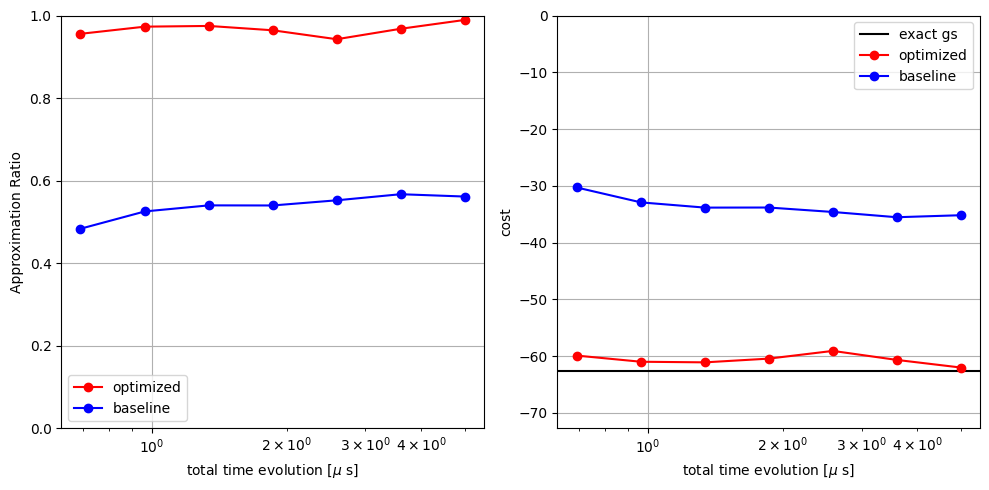

In [12]:
#read output of the costs
output = pd.read_csv(f"results/output_{str(N)}_{str(T)}_{ii}.csv")
#assign costs
print(output)
cost = output["cost"][1:9]
print(cost)
cost_baseline = output["cost_baseline"][1:9]
#ground state energy
gs = output["exact_gs"][1]
print(gs)
#time in nanoseconds
times = np.array(output["time"][1:9])
#read schedule dataframe 
omega_data = np.load(f"results/omega_schedules_{str(N)}_{str(T)}_{0}.npy")
delta_data = np.load(f"results/delta_schedules_{str(N)}_{str(T)}_{0}.npy")

ar = [1-abs((gs - x)/gs) for x in cost]
ar_baseline = [1-abs((gs - x)/gs) for x in cost_baseline]

fig,axs = plt.subplots(ncols = 2, nrows = 1,figsize = (10,5))


axs[0].plot(times/1000,ar,'ro-',label='optimized')
axs[0].plot(times/1000,ar_baseline,'bo-',label='baseline')
axs[0].set_xlabel(r'total time evolution [$\mu$ s]')
axs[0].set_ylabel(r'Approximation Ratio')
axs[0].set_ylim(0,1)

axs[1].axhline(y = gs, color = 'k', linestyle = '-',label = 'exact gs')
axs[1].plot(times/1000,cost,'ro-',label='optimized')
axs[1].plot(times/1000,cost_baseline,'bo-',label='baseline')
axs[1].set_xlabel(r'total time evolution [$\mu$ s]')
axs[1].set_ylabel(r'cost')
axs[1].set_ylim(gs-10,0)

for ax in axs:
    ax.set_xscale('log')
    ax.legend()
    ax.grid()
    #ax.set_ylim(0,1)
fig.tight_layout()
fig.savefig(f'ar_size_N{str(N)}_T{str(T)}.png')

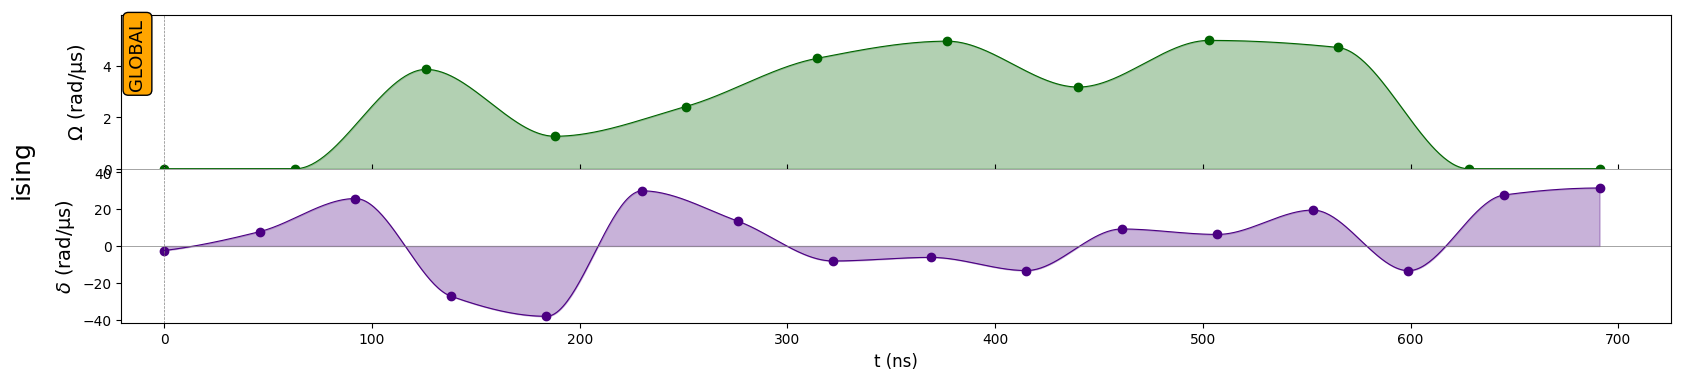

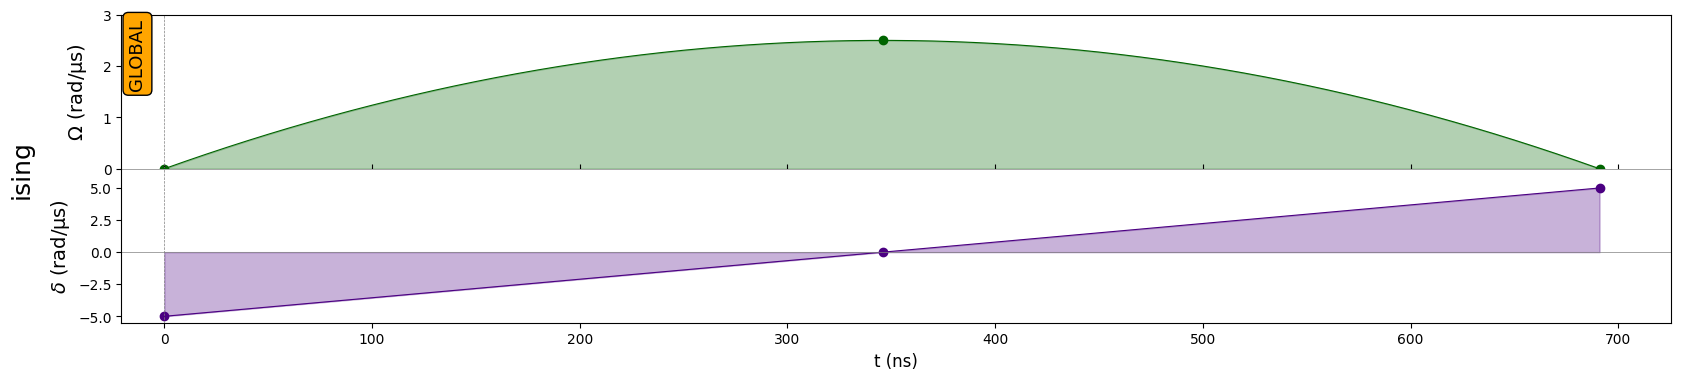

In [13]:
#select a time index
i = 3
t = times[0]
omega = omega_data[i]
delta = delta_data[i]

omega_pulse = build_omega(omega)
delta_pulse = build_delta(delta)

# Construct the adiabatic pulse
adiabatic_pulse = Pulse(
    InterpolatedWaveform(t, omega_pulse),
    InterpolatedWaveform(t, delta_pulse),
    0,
)

# Create a sequence with the specified pulse
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")

seq.draw()

Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive

adiabatic_pulse = Pulse(
    InterpolatedWaveform(t, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(t, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [16]:
treshold = 0.5
min_index = np.argwhere(np.array(ar)>treshold).min()
min_index_baseline = np.argwhere(np.array(ar_baseline)>treshold).min()
delta_t = abs(times[min_index]-times[min_index_baseline])/times[min_index_baseline]

print(f"Time saved : {delta_t*100:.2f}%")

Time saved : 28.22%


In [17]:
all_states = [''.join(map(str, bits)) for bits in product([0, 1], repeat=N*T)]

#obtain target outage for energy grid
P = params['P']
all_states_array = 2*np.array([list(map(int, list(x))) for x in all_states])
all_states_array -= np.asarray(1)
grid_violations = []
for i in all_states_array:
    i = i.reshape(-1,N)
    i = np.sum(i,axis=0)
    i -= np.asarray(P)
    i = abs(i)
    #mean violation over a single solution
    grid_violations.append(np.mean(i))

grid_violations = np.array(grid_violations)
mean_violation = np.mean(grid_violations)
print(f"Average reduction in stress of the grid: {mean_violation*100:.2f}%")

Average reduction in stress of the grid: 100.00%
